In [60]:
# !pip install tensorflow_addons

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 736.6/736.6 kB 7.7 MB/s eta 0:00:00



[notice] A new release of pip available: 22.2.2 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Libraries

In [22]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from kerastuner import HyperModel
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Lambda, concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

# Data Preprocessing

In [2]:
# Define data path
data_path = "C:\\Users\\684637\\Documents\\AAI\\train"

# Define classes
classes = ["closed", "no_yawn", "open", "yawn"]

# Load images and labels
images = []
labels = []

for c in classes:
    path = os.path.join(data_path, c)
    class_num = classes.index(c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, (256, 256), 3)
        images.append(img_array)
        labels.append(class_num)

# Convert images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)


## Train-test split

In [3]:
# Split the data into train , validation and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

x_train, X_val, Y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)


# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))
y_val = to_categorical(y_val, num_classes=len(classes))



## Shape of the data

In [4]:
print (x_train.shape)
print (X_train.shape)
print (X_test.shape)
print (X_val.shape)
print (y_train.shape)

(2320, 256, 256)
(2320, 256, 256)
(580, 256, 256)
(580, 256, 256)
(2320, 4)


## Data Visualization

In [5]:
# Define a function to plot images
def plot_images(images, labels):
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.ravel()

    for i in np.arange(0, 9):
        axes[i].imshow(images[i])
        axes[i].set_title(labels[i])
        axes[i].axis('off')

    plt.subplots_adjust(hspace=0.5)

C:\Program Files\Python310\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


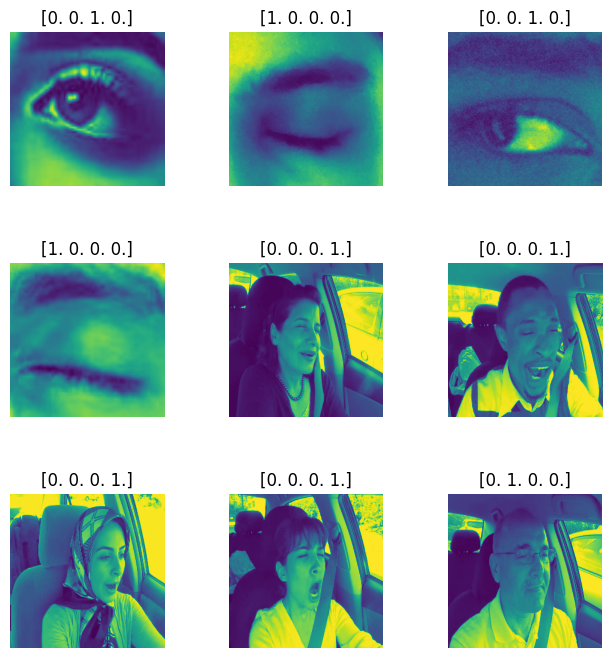

In [6]:
# Plot images from x_train
plot_images(X_train[:9], y_train[:9])

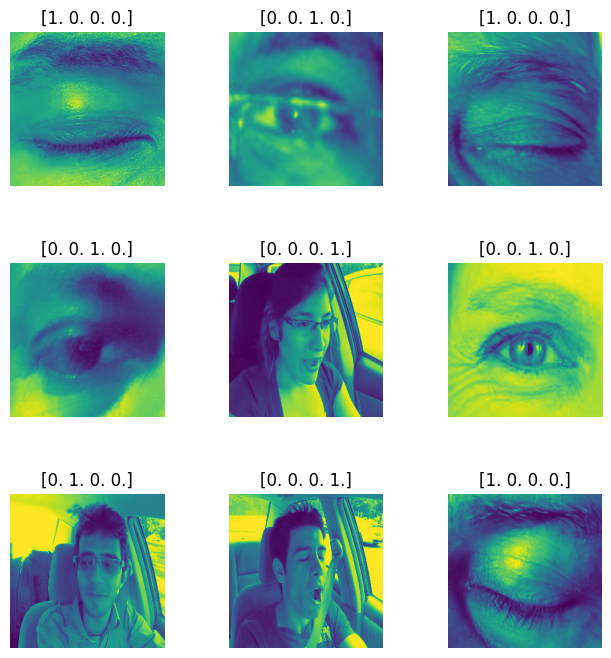

In [7]:
# Plot images from x_val
plot_images(X_val[:9], y_val[:9])

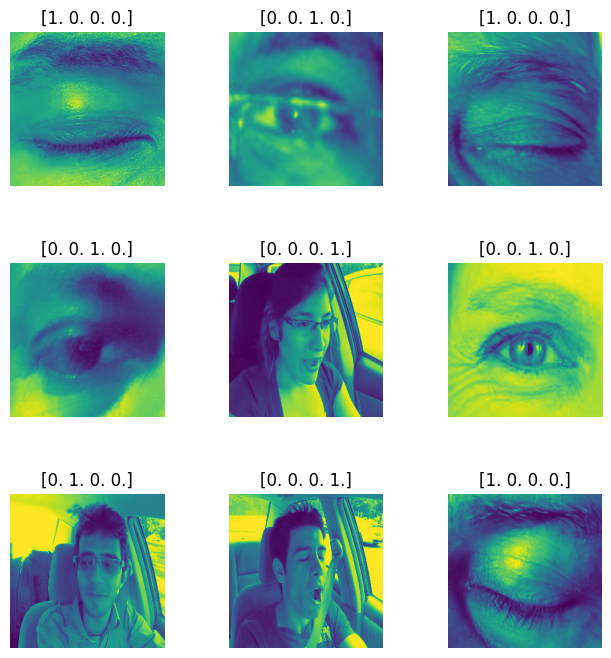

In [8]:
# Plot images from x_test
plot_images(X_test[:9], y_test[:9])

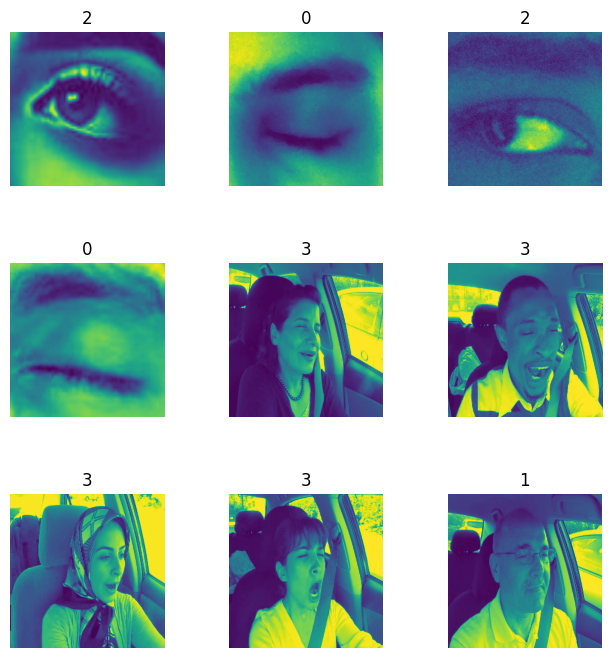

In [9]:
# Plot images from x_test
plot_images(x_train[:9], Y_train[:9])

# Define and compile your Autoencoder model and train it on X_train

In [11]:
latent_dim = 128 

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(256 * 256, activation='sigmoid'),
          layers.Reshape((256, 256))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [12]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

## Training the Autoencoder

In [13]:
# Train the model using x_train
history = autoencoder.fit(X_train, X_train,
                epochs=10,
                shuffle=True,
                validation_data=(X_val, X_val))

Epoch 1/10
73/73 [==============================] - 2s 7ms/step - loss: 0.0543 - val_loss: 0.0421
Epoch 2/10
73/73 [==============================] - 0s 5ms/step - loss: 0.0412 - val_loss: 0.0374
Epoch 3/10
73/73 [==============================] - 0s 5ms/step - loss: 0.0376 - val_loss: 0.0366
Epoch 4/10
73/73 [==============================] - 0s 6ms/step - loss: 0.0369 - val_loss: 0.0352
Epoch 5/10
73/73 [==============================] - 0s 5ms/step - loss: 0.0357 - val_loss: 0.0339
Epoch 6/10
73/73 [==============================] - 0s 5ms/step - loss: 0.0367 - val_loss: 0.0341
Epoch 7/10
73/73 [==============================] - 0s 5ms/step - loss: 0.0352 - val_loss: 0.0338
Epoch 8/10
73/73 [==============================] - 0s 5ms/step - loss: 0.0338 - val_loss: 0.0320
Epoch 9/10
73/73 [==============================] - 0s 6ms/step - loss: 0.0339 - val_loss: 0.0346
Epoch 10/10
73/73 [==============================] - 0s 5ms/step - loss: 0.0343 - val_loss: 0.0318


In [14]:
# Evaluate autoencoder model on test data
autoencoder.evaluate(X_test, X_test)

19/19 [==============================] - 0s 2ms/step - loss: 0.0318


0.031802620738744736

In [15]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128)               8388736   
                                                                 
 sequential_1 (Sequential)   (None, 256, 256)          8454144   
                                                                 
Total params: 16,842,880
Trainable params: 16,842,880
Non-trainable params: 0
_________________________________________________________________


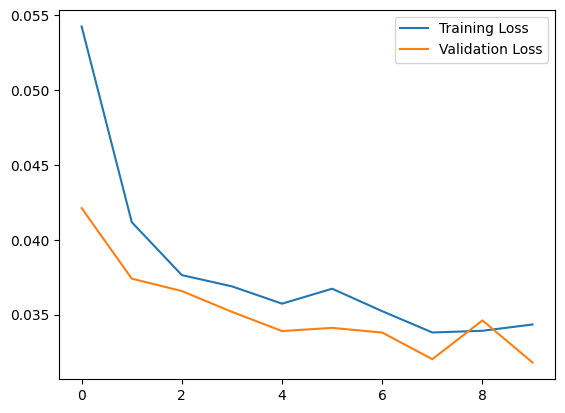

In [16]:
#plot the Train and validation Loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

## Encoding and Decoding the autoencoder

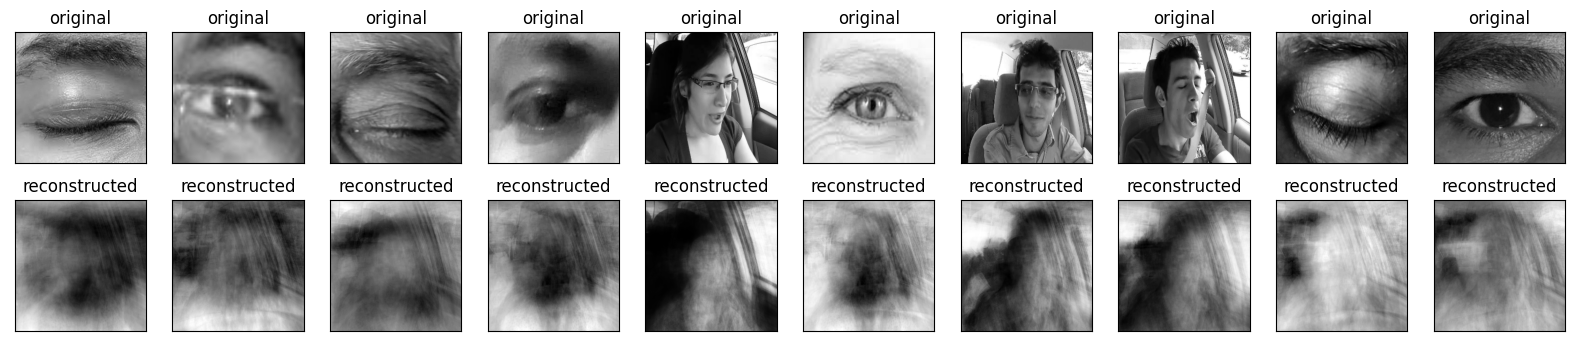

In [21]:
# Encoding/Decoding
encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Image Denoising

In [5]:
# Reimport the dataset to omit modifications made earlier
# Define data path
data_path = "D:\\684637 AAI\\train"

# Define classes
classes = ["closed", "no_yawn", "open", "yawn"]

# Load images and labels
images = []
labels = []

for c in classes:
    path = os.path.join(data_path, c)
    class_num = classes.index(c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, (256, 256), 3)
        images.append(img_array)
        labels.append(class_num)

# Convert images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split the data into train , validation and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))



print (X_train.shape)

x_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

print(x_train.shape)

(2320, 256, 256)
(2320, 256, 256, 1)


## Adding random noise to the images


In [6]:
#Adding random noise to the images
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = X_test + noise_factor * tf.random.normal(shape=X_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

## Plot the noisy images


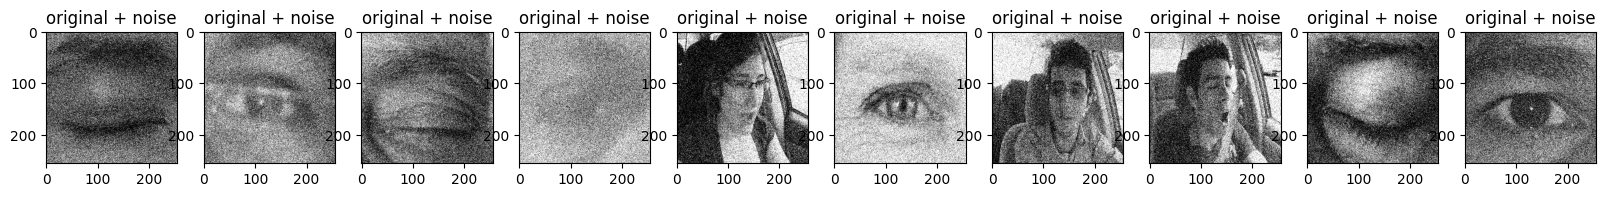

In [7]:
#plot the noisy images
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

## Convolutional Autoencoder

In [8]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(256, 256, 1)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])
          #layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

In [9]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [10]:
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                #batch_size=2320, # set batch size to match number of samples in x_train
                shuffle=True,
                validation_data=(x_test_noisy, X_test))

Epoch 1/10
73/73 [==============================] - 9s 19ms/step - loss: 0.0550 - val_loss: 0.0275
Epoch 2/10
73/73 [==============================] - 1s 15ms/step - loss: 0.0121 - val_loss: 0.0055
Epoch 3/10
73/73 [==============================] - 1s 15ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 4/10
73/73 [==============================] - 1s 15ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 5/10
73/73 [==============================] - 1s 15ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 6/10
73/73 [==============================] - 1s 15ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 7/10
73/73 [==============================] - 1s 15ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 8/10
73/73 [==============================] - 1s 15ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 9/10
73/73 [==============================] - 1s 15ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 10/10
73/73 [==============================] - 1s 15ms/step - loss: 0.0031 - val_loss: 0.0030


In [11]:
# Evaluate autoencoder model on test data
autoencoder.evaluate(x_test_noisy, X_test)

19/19 [==============================] - 0s 6ms/step - loss: 0.0030


0.0029905750416219234

In [12]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [13]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 128, 128, 8)      584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 256, 256, 16)     1168      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 256, 256, 1)      145       
 ranspose)                                                       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


## Visualizing the performance

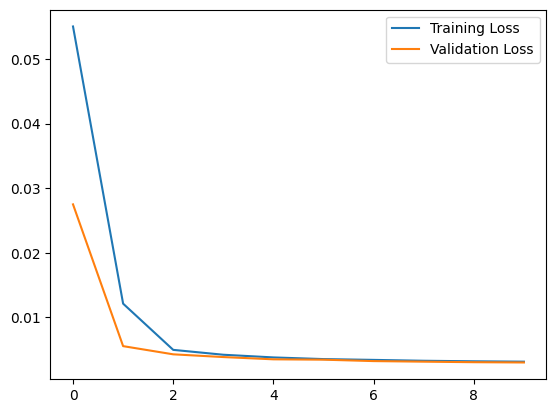

In [14]:
#plot the Train and validation Loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend() 

## Plotting both the noisy images and the denoised images produced by the autoencoder.


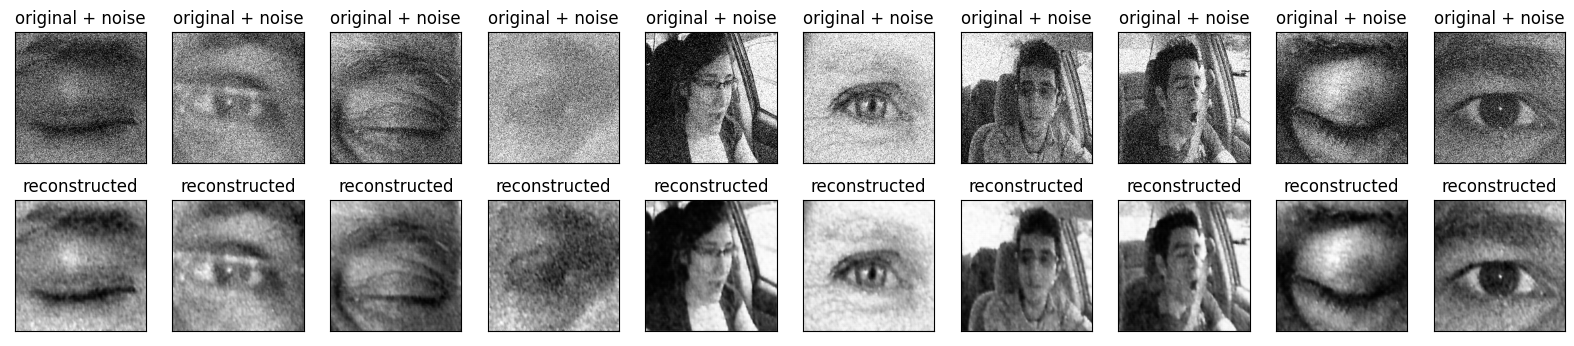

In [15]:
# Plotting both the noisy images and the denoised images produced by the autoencoder.

encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Cross-checking the shape of the variables

In [16]:
print(X_train.shape)
print(x_train_noisy.shape)
print (X_test.shape)
print(y_train.shape)  
print(y_test.shape)
print(encoded_imgs.shape)


(2320, 256, 256)
(2320, 256, 256, 1)
(580, 256, 256, 1)
(2320, 4)
(580, 4)
(580, 64, 64, 8)


## Chunking the data
Due to low memory size of my computer, the data was chunked for easy running of the model

In [17]:
chunk_size = 10  # Adjust this value based on your system's memory capacity.

encoded_imgs_train = []
decoded_imgs_train = []

for i in range(0, len(x_train_noisy), chunk_size):
    chunk = x_train_noisy[i:i+chunk_size]
    encoded_chunk = autoencoder.encoder(chunk).numpy()
    decoded_chunk = autoencoder.decoder(encoded_chunk).numpy()
    
    encoded_imgs_train.append(encoded_chunk)
    decoded_imgs_train.append(decoded_chunk)

encoded_imgs_train = np.concatenate(encoded_imgs_train, axis=0)
decoded_imgs_train = np.concatenate(decoded_imgs_train, axis=0)


### Cross-check the variable shape

In [18]:
print(y_train.shape)  
print(decoded_imgs_train.shape)  
print(decoded_imgs.shape)  

(2320, 4)
(2320, 256, 256, 1)
(580, 256, 256, 1)


In [42]:
# encoded_imgs_train = autoencoder.encoder(x_train_noisy).numpy()
# decoded_imgs_train = autoencoder.decoder(encoded_imgs_train).numpy()

# The Hybrid Model
This model uses the EfficientNet base model

In [43]:
#Hybrid model

num_classes = len(classes)

class Hybrid(Model):
    def __init__(self):
        super(Hybrid, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)),
          layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)]) # Update the output size to 32x32

        self.efficientnet = tf.keras.applications.EfficientNetB0(
            include_top=False, weights=None, input_shape=(32, 32, 64), pooling='avg'
        )

        self.classifier = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        efficientnet_out = self.efficientnet(encoded)
        classification = self.classifier(efficientnet_out)
        return classification

X_train = X_train.reshape(-1, 256, 256, 1)
X_test = X_test.reshape(-1, 256, 256, 1)

hybrid_model = Hybrid()
hybrid_model.compile(optimizer='adam', loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
history = hybrid_model.fit(X_train, y_train,
                epochs=20,
                shuffle=True,
                validation_data=(X_test, y_test))


C:\Program Files\Python310\lib\site-packages\keras\applications\efficientnet.py:292: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 64 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Epoch 1/20
73/73 [==============================] - 9s 61ms/step - loss: 0.9650 - accuracy: 0.5431 - val_loss: 1.4512 - val_accuracy: 0.2586
Epoch 2/20
73/73 [==============================] - 3s 42ms/step - loss: 0.6450 - accuracy: 0.6966 - val_loss: 1.5902 - val_accuracy: 0.2603
Epoch 3/20
73/73 [==============================] - 3s 43ms/step - loss: 0.5381 - accuracy: 0.7565 - val_loss: 1.6568 - val_accuracy: 0.2603
Epoch 4/20
73/73 [==============================] - 3s 43ms/step - loss: 0.4507 - accuracy: 0.8043 - val_loss: 1.8846 - val_accuracy: 0.2603
Epoch 5/20
73/73 [==============================] - 3s 43ms/step - loss: 0.4068 - accuracy: 0.8203 - val_loss: 2.7785 - val_accuracy: 0.2603
Epoch 6/20
73/73 [==============================] - 3s 43ms/step - loss: 0.3698 - accuracy: 0.8401 - val_loss: 2.2275 - val_accuracy: 0.2603
Epoch 7/20
73/73 [==============================] - 3s 42ms/step - loss: 0.3184 - accuracy: 0.8634 - val_loss: 3.8894 - val_accuracy: 0.2603
Epoch 8/20
73

## Plot the Train and Validation Loss

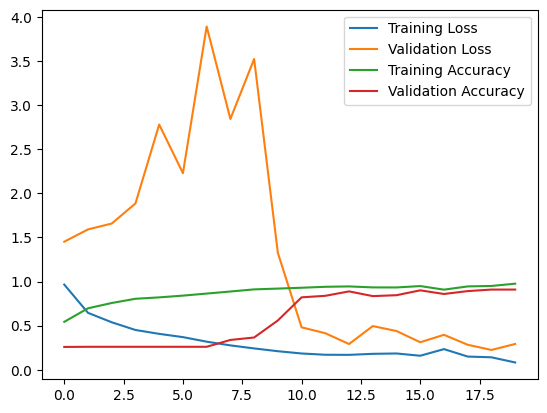

In [44]:
#plot the Train and validation Loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

#plot the Train and validation accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()

## EfficientNetB1

Epoch 1/20
73/73 [==============================] - 11s 73ms/step - loss: 1.0305 - accuracy: 0.5082 - val_loss: 1.5742 - val_accuracy: 0.2586
Epoch 2/20
73/73 [==============================] - 4s 60ms/step - loss: 0.8165 - accuracy: 0.5892 - val_loss: 1.4463 - val_accuracy: 0.2586
Epoch 3/20
73/73 [==============================] - 5s 62ms/step - loss: 0.6490 - accuracy: 0.6616 - val_loss: 1.5643 - val_accuracy: 0.2586
Epoch 4/20
73/73 [==============================] - 5s 62ms/step - loss: 0.6003 - accuracy: 0.6996 - val_loss: 1.6337 - val_accuracy: 0.2603
Epoch 5/20
73/73 [==============================] - 4s 61ms/step - loss: 0.5209 - accuracy: 0.7453 - val_loss: 1.6251 - val_accuracy: 0.2586
Epoch 6/20
73/73 [==============================] - 4s 61ms/step - loss: 0.4783 - accuracy: 0.7862 - val_loss: 2.2998 - val_accuracy: 0.2603
Epoch 7/20
73/73 [==============================] - 4s 60ms/step - loss: 0.4434 - accuracy: 0.8013 - val_loss: 3.0907 - val_accuracy: 0.2603
Epoch 8/20
7

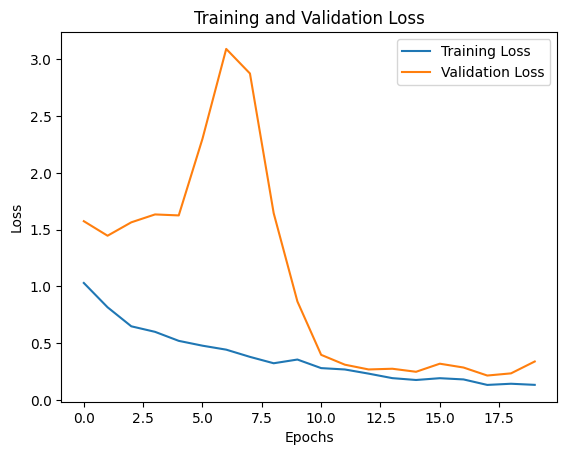

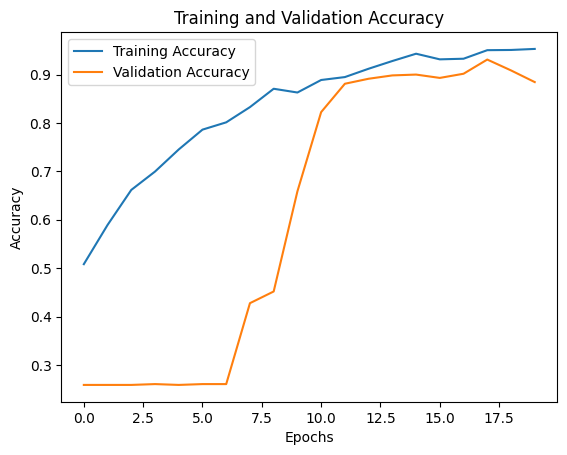

In [50]:
num_classes = len(classes)

class Hybrid(Model):
    def __init__(self):
        super(Hybrid, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)),
          layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)]) # Update the output size to 32x32

        self.efficientnet = tf.keras.applications.EfficientNetB1(
            include_top=False, weights=None, input_shape=(32, 32, 64), pooling='avg'
        )

        self.classifier = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        efficientnet_out = self.efficientnet(encoded)
        classification = self.classifier(efficientnet_out)
        return classification

X_train = X_train.reshape(-1, 256, 256, 1)
X_test = X_test.reshape(-1, 256, 256, 1)

hybrid_model = Hybrid()
hybrid_model.compile(optimizer='adam', loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
history = hybrid_model.fit(X_train, y_train,
                epochs=20,
                shuffle=True,
                validation_data=(X_test, y_test))



#Plot the training and validation loss
plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#Plot the training and validation accuracy
plt.figure()
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


# Create a custom hypermodel that includes EfficientNet variants
To avoid running multiple cells separately, combining the variants into a hyperparameter model is done here.
The model Was trained on the X_train data that was not autoencoded.

In [35]:
# Create a custom hypermodel that includes EfficientNet variants

class MyHyperModel(HyperModel):

    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        efficientnet_variant = hp.Choice('efficientnet_variant', values=['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6'])#, 'B7'])

        if efficientnet_variant == 'B0':
            base_model = EfficientNetB0(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B1':
            base_model = EfficientNetB1(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B2':
            base_model = EfficientNetB2(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B3':
            base_model = EfficientNetB3(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B4':
            base_model = EfficientNetB4(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B5':
            base_model = EfficientNetB5(include_top=False, input_shape=self.input_shape, weights='imagenet')
#         elif efficientnet_variant == 'B6':
#             base_model = EfficientNetB6(include_top=False, input_shape=self.input_shape, weights='imagenet')
        else:
            base_model = EfficientNetB6(include_top=False, input_shape=self.input_shape, weights='imagenet')

        model = tf.keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return model

input_shape = (256, 256, 1)  # Adjust input shape accordingly
num_classes = len(classes)   # Replace `classes` with the list of your target classes

# Convert single-channel input data to 3-channel format
X_train_3channel = np.stack((X_train,) * 3, axis=-1)
X_test_3channel = np.repeat(X_test, 3, axis=-1)

hypermodel = MyHyperModel(input_shape=(256, 256, 3), num_classes=num_classes)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,  # Adjust the number of trials based on available resources
    executions_per_trial=1,
    directory='my_dir',
    project_name='efficientnet_hyperparameter_tuning_3'
)

tuner.search(X_train_3channel, y_train, epochs=10, validation_split=0.2)  # Adjust the number of epochs based on available resources

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
model = hypermodel.build(best_hps)
model.fit(X_train_3channel, y_train, epochs=10, validation_split=0.2, batch_size = 8)  # Adjust the number of epochs based on available resources

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_3channel, y_test)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")



INFO:tensorflow:Reloading Tuner from my_dir\efficientnet_hyperparameter_tuning_3\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
232/232 [==============================] - 51s 188ms/step - loss: 0.2348 - accuracy: 0.9219 - val_loss: 0.8553 - val_accuracy: 0.6810
Epoch 2/10
232/232 [==============================] - 43s 184ms/step - loss: 0.0338 - accuracy: 0.9914 - val_loss: 0.4856 - val_accuracy: 0.8405
Epoch 3/10
232/232 [==============================] - 42s 182ms/step - loss: 0.0174 - accuracy: 0.9941 - val_loss: 0.0402 - val_accuracy: 0.9914
Epoch 4/10
232/232 [==============================] - 43s 185ms/step - loss: 0.0185 - accuracy: 0.9962 - val_loss: 1.7939 - val_accuracy: 0.3987
Epoch 5/10
232/232 [==============================] - 43s 186ms/step - loss: 0.0159 - accuracy: 0.9962 - val_loss: 2.3243 - val_accuracy: 0.1875
Epoch 6/10
232/232 [==============================] - 43s 185ms/step - loss: 0.0092 - accuracy: 0.9978 - val_loss: 0.0193 - val_accuracy: 0.9957

## Get the best trial and highest validation accuracy


In [36]:
# Get the best trial and highest validation accuracy
best_trial_3 = tuner.oracle.get_best_trials(num_trials=1)[0]
best_val_accuracy_3 = best_trial_3.metrics.get_best_value('val_accuracy')

# Print the best validation accuracy and test accuracy
print(f"Best validation accuracy: {best_val_accuracy_3:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")


Best validation accuracy: 0.9914
Test accuracy: 0.6845


## Training, Validation Loss/Accuracy and Confusion Matrix

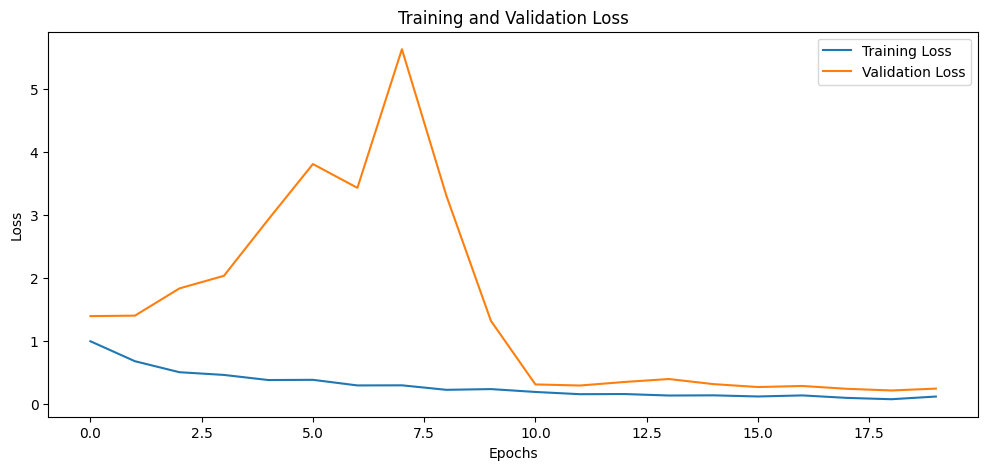

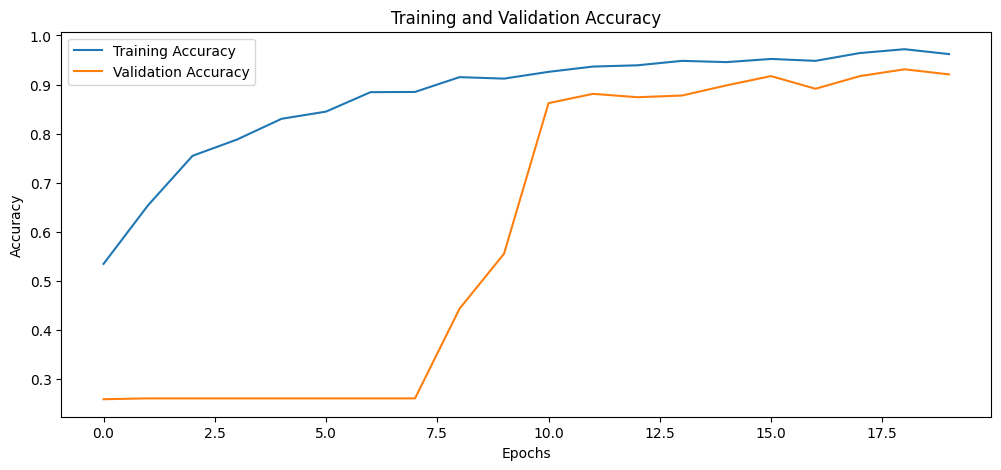

19/19 [==============================] - 3s 97ms/step


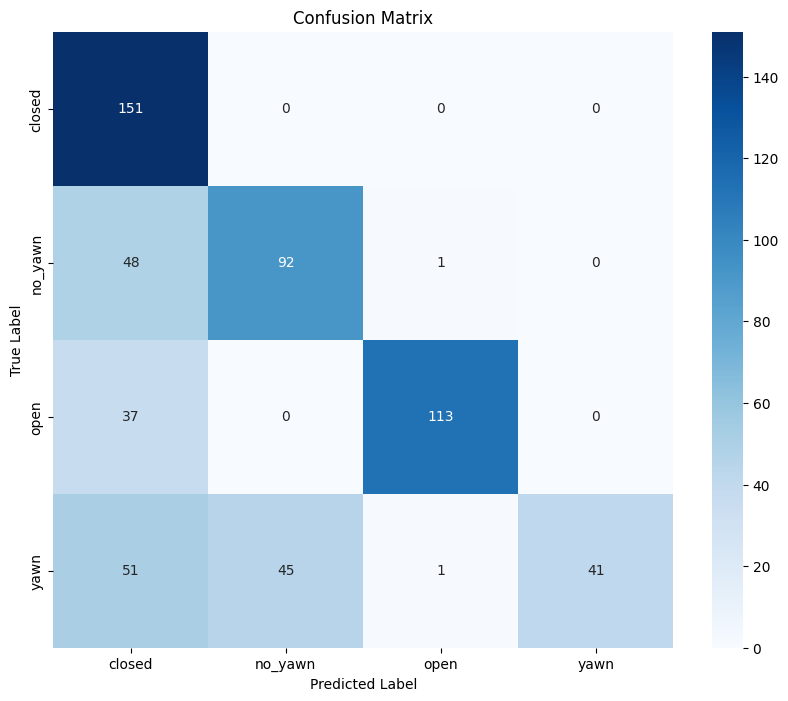

In [38]:
from sklearn.metrics import confusion_matrix, classification_report


# Plot the training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Predict the class labels for the test set
y_pred = model.predict(X_test_3channel)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Performance metrics for the Hyperparameter

In [39]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted')

# Create a dataframe to display the evaluation metrics
metrics_3 = pd.DataFrame({
    'Metric': ['Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F1 Score'],
    'Value': [accuracy, precision, recall, f1_score]
})

metrics_3

Metric     Value
0            Accuracy  0.684483
1  Weighted Precision  0.792282
2     Weighted Recall  0.684483
3   Weighted F1 Score  0.669966

# Resizing the images in the dataset

In [61]:
# Function to resize images

def resize_images(images, new_size=(128, 128)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, new_size)
        resized_images.append(resized_img)
    return np.array(resized_images)

# Create a custom hypermodel that includes EfficientNet variants
class MyHyperModel(HyperModel):

    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        efficientnet_variant = hp.Choice('efficientnet_variant', values=['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6'])#, 'B7'])

        if efficientnet_variant == 'B0':
            base_model = EfficientNetB0(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B1':
            base_model = EfficientNetB1(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B2':
            base_model = EfficientNetB2(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B3':
            base_model = EfficientNetB3(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B4':
            base_model = EfficientNetB4(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B5':
            base_model = EfficientNetB5(include_top=False, input_shape=self.input_shape, weights='imagenet')
#         elif efficientnet_variant == 'B6':
#             base_model = EfficientNetB6(include_top=False, input_shape=self.input_shape, weights='imagenet')
        else:
            base_model = EfficientNetB6(include_top=False, input_shape=self.input_shape, weights='imagenet')

        model = tf.keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return model

input_shape = (128, 128, 1)  # Adjust input shape accordingly
num_classes = len(classes)   # Replace `classes` with the list of your target classes

# Convert single-channel input data to 3-channel format
X_train_3channel = np.repeat(X_train, 3, axis=-1)
X_test_3channel = np.repeat(X_test, 3, axis=-1)

# Resize the images to the new size
new_size = (128, 128)
X_train_resized = resize_images(X_train_3channel, new_size)
X_test_resized = resize_images(X_test_3channel, new_size)


hypermodel = MyHyperModel(input_shape=(128, 128, 3), num_classes=num_classes)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,  # Adjust the number of trials based on available resources
    executions_per_trial=1,
    directory='my_dir',
    project_name='efficientnet_hyperparameter_tuning'
)

tuner.search(X_train_resized, y_train, epochs=10, validation_split=0.2)  # Adjust the number of epochs based on available resources

# Get the optimal hyperparameters
best_hps_2 = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best EfficientNet variant
best_efficientnet_variant = best_hps_2.get('efficientnet_variant')
print(f"Best EfficientNet variant: {best_efficientnet_variant}")

# Build the model with the optimal hyperparameters and train it
model = hypermodel.build(best_hps_2)
model.fit(X_train_resized, y_train, epochs=10, validation_split=0.2, batch_size = 8)  # Adjust the number of epochs based on available resources

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_resized, y_test)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

Trial 10 Complete [00h 02m 08s]
val_accuracy: 0.5840517282485962

Best val_accuracy So Far: 0.954741358757019
Total elapsed time: 00h 16m 38s
INFO:tensorflow:Oracle triggered exit
Best EfficientNet variant: B6
Epoch 1/10
232/232 [==============================] - 40s 127ms/step - loss: 0.4629 - accuracy: 0.7990 - val_loss: 1.7321 - val_accuracy: 0.2694
Epoch 2/10
232/232 [==============================] - 27s 117ms/step - loss: 0.2149 - accuracy: 0.9219 - val_loss: 0.4647 - val_accuracy: 0.8556
Epoch 3/10
232/232 [==============================] - 27s 117ms/step - loss: 0.1154 - accuracy: 0.9650 - val_loss: 0.1738 - val_accuracy: 0.9461
Epoch 4/10
232/232 [==============================] - 28s 119ms/step - loss: 0.0607 - accuracy: 0.9828 - val_loss: 0.1522 - val_accuracy: 0.9504
Epoch 5/10
232/232 [==============================] - 28s 119ms/step - loss: 0.0478 - accuracy: 0.9844 - val_loss: 0.4529 - val_accuracy: 0.8772
Epoch 6/10
232/232 [==============================] - 28s 119ms/s

## Get the best trial and highest validation accuracy


In [71]:
# Get the best trial and highest validation accuracy
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_val_accuracy = best_trial.metrics.get_best_value('val_accuracy')

# Print the best validation accuracy and test accuracy
print(f"Best validation accuracy: {best_val_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")


Best validation accuracy: 0.9547
Test accuracy: 0.9914


## Plot the training, validation loss and accuracy, and Confusion Matrix


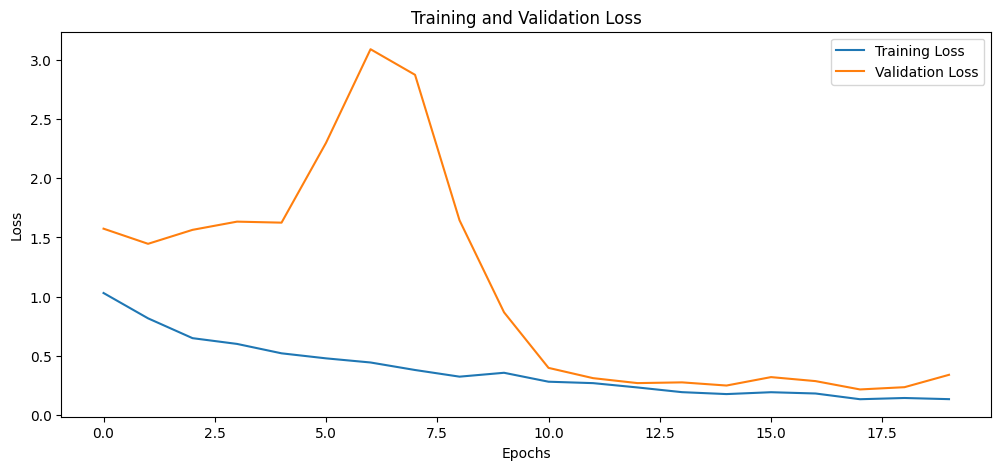

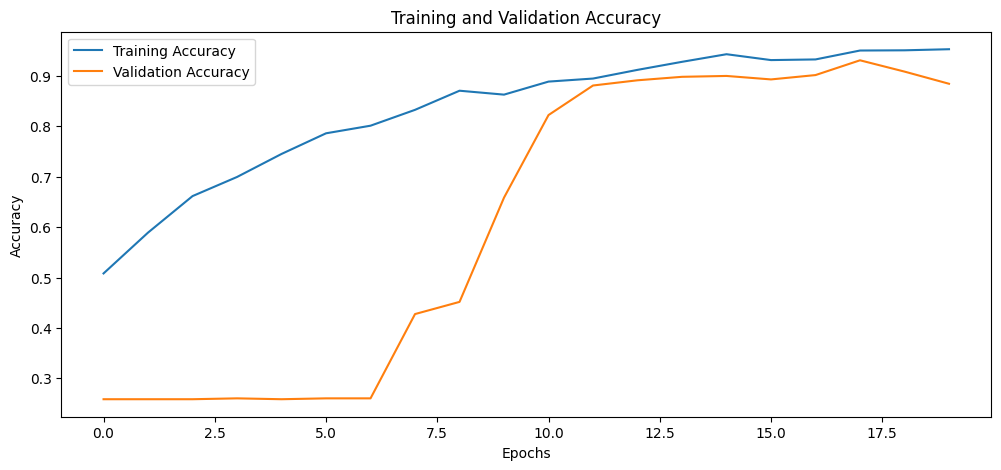

19/19 [==============================] - 1s 48ms/step


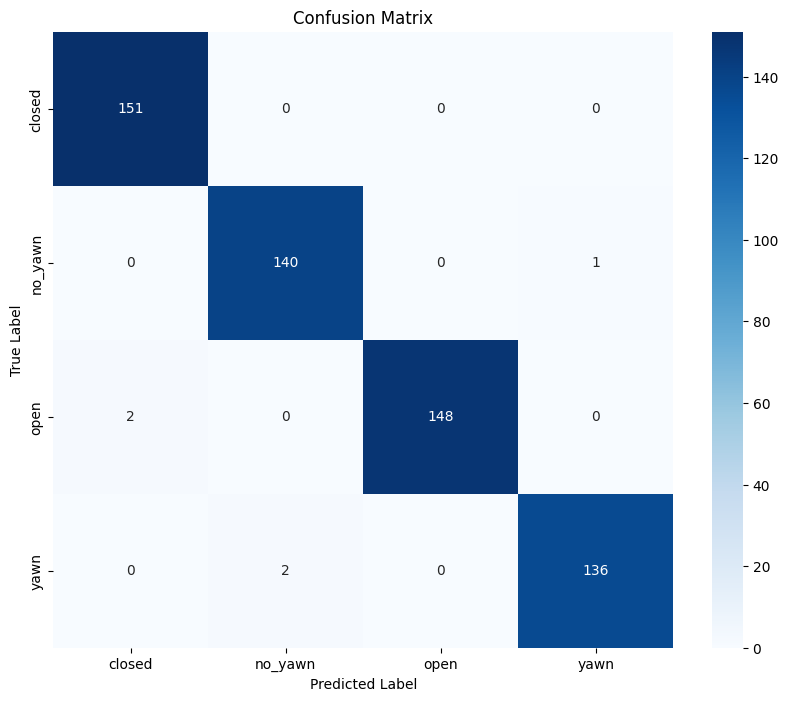

In [66]:
from sklearn.metrics import confusion_matrix, classification_report


# Plot the training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Predict the class labels for the test set
y_pred = model.predict(X_test_resized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Performance Metrics

In [85]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted')

# Create a dataframe to display the evaluation metrics
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F1 Score'],
    'Value': [accuracy, weighted_precision, weighted_recall, weighted_f1]
})

metrics

Metric     Value
0            Accuracy  0.991379
1  Weighted Precision  0.885984
2     Weighted Recall  0.870690
3   Weighted F1 Score  0.869512

In [79]:
# Calculate precision, recall, F1 score, and support for each class
precision_scores, recall_scores, f1_scores, support = precision_recall_fscore_support(y_true, y_pred, average=None)

# Compute weighted average scores
weighted_precision = np.average(precision_scores, weights=support)
weighted_recall = np.average(recall_scores, weights=support)
weighted_f1 = np.average(f1_scores, weights=support)

print(f"Weighted precision: {weighted_precision:.4f}")
print(f"Weighted recall: {weighted_recall:.4f}")
print(f"Weighted F1 score: {weighted_f1:.4f}")

Weighted precision: 0.8860
Weighted recall: 0.8707
Weighted F1 score: 0.8695


# Base Hybrid Model using the Autoencoded data

C:\Program Files\Python310\lib\site-packages\keras\applications\efficientnet.py:292: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 64 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Epoch 1/20
73/73 [==============================] - 9s 60ms/step - loss: 0.9994 - accuracy: 0.5345 - val_loss: 1.3982 - val_accuracy: 0.2586
Epoch 2/20
73/73 [==============================] - 3s 42ms/step - loss: 0.6830 - accuracy: 0.6539 - val_loss: 1.4054 - val_accuracy: 0.2603
Epoch 3/20
73/73 [==============================] - 3s 44ms/step - loss: 0.5089 - accuracy: 0.7547 - val_loss: 1.8370 - val_accuracy: 0.2603
Epoch 4/20
73/73 [==============================] - 3s 43ms/step - loss: 0.4658 - accuracy: 0.7879 - val_loss: 2.0367 - val_accuracy: 0.2603
Epoch 5/20
73/73 [==============================] - 3s 43ms/step - loss: 0.3845 - accuracy: 0.8302 - val_loss: 2.9321 - val_accuracy: 0.2603
Epoch 6/20
73/73 [==============================] - 3s 43ms/step - loss: 0.3881 - accuracy: 0.8448 - val_loss: 3.8083 - val_accuracy: 0.2603
Epoch 7/20
73/73 [==============================] - 3s 44ms/step - loss: 0.2993 - accuracy: 0.8845 - val_loss: 3.4312 - val_accuracy: 0.2603
Epoch 8/20
73

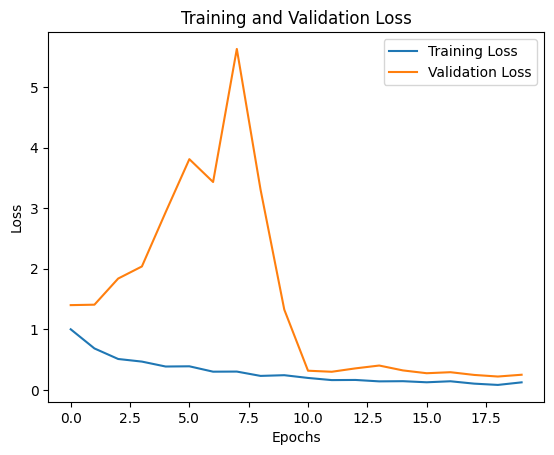

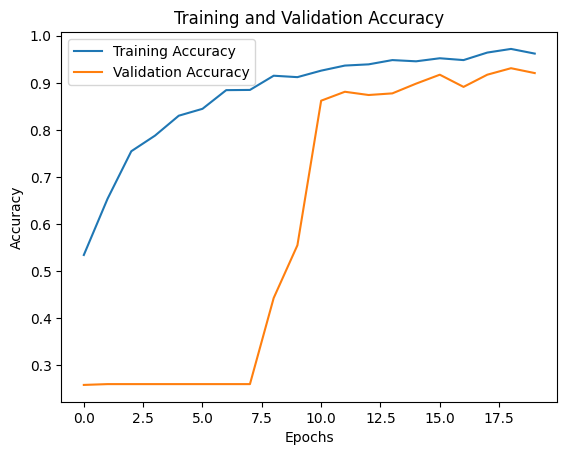

In [19]:
num_classes = len(classes)

class Hybrid(Model):
    def __init__(self):
        super(Hybrid, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)),
          layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)]) # Update the output size to 32x32

        self.efficientnet = tf.keras.applications.EfficientNetB0(
            include_top=False, weights=None, input_shape=(32, 32, 64), pooling='avg'
        )

        self.classifier = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        efficientnet_out = self.efficientnet(encoded)
        classification = self.classifier(efficientnet_out)
        return classification

decoded_X_train = decoded_imgs_train.reshape(-1, 256, 256, 1)
decoded_X_test = decoded_imgs.reshape(-1, 256, 256, 1)

hybrid_model = Hybrid()
hybrid_model.compile(optimizer='adam', loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
history = hybrid_model.fit(decoded_X_train, y_train,
                epochs=20,
                shuffle=True,
                validation_data=(decoded_X_test, y_test))



#Plot the training and validation loss
plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#Plot the training and validation accuracy
plt.figure()
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


# Hyperparameter using Autoencoded images

In [88]:
# Create a custom hypermodel that includes EfficientNet variants
class MyHyperModel(HyperModel):

    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        efficientnet_variant = hp.Choice('efficientnet_variant', values=['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6'])#, 'B7'])

        if efficientnet_variant == 'B0':
            base_model = EfficientNetB0(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B1':
            base_model = EfficientNetB1(include_top=False, input_shape=self.input_shape, weights='imagenet')
#         elif efficientnet_variant == 'B2':
#             base_model = EfficientNetB2(include_top=False, input_shape=self.input_shape, weights='imagenet')
#         elif efficientnet_variant == 'B3':
#             base_model = EfficientNetB3(include_top=False, input_shape=self.input_shape, weights='imagenet')
#         elif efficientnet_variant == 'B4':
#             base_model = EfficientNetB4(include_top=False, input_shape=self.input_shape, weights='imagenet')
#         elif efficientnet_variant == 'B5':
#             base_model = EfficientNetB5(include_top=False, input_shape=self.input_shape, weights='imagenet')
#         elif efficientnet_variant == 'B6':
#             base_model = EfficientNetB6(include_top=False, input_shape=self.input_shape, weights='imagenet')
        else:
            base_model = EfficientNetB2(include_top=False, input_shape=self.input_shape, weights='imagenet')

        model = tf.keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return model

input_shape = (256, 256, 1)  # Adjust input shape accordingly
num_classes = len(classes)   # Replace `classes` with the list of your target classes

# Convert single-channel input data to 3-channel format
X_train_3channel = np.repeat(decoded_imgs_train, 3, axis=-1)
X_test_3channel = np.repeat(decoded_imgs, 3, axis=-1)

hypermodel = MyHyperModel(input_shape=(256, 256, 3), num_classes=num_classes)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,  # Adjust the number of trials based on available resources
    executions_per_trial=1,
    directory='my_dir',
    project_name='efficientnet_hyperparameter_tuning_6'
)

tuner.search(X_train_3channel, y_train, epochs=10, validation_split=0.2)  # Adjust the number of epochs based on available resources

# Get the optimal hyperparameters
best_hps_6 = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
model = hypermodel.build(best_hps_6)
model.fit(X_train_3channel, y_train, epochs=10, validation_split=0.2, batch_size = 4)  # Adjust the number of epochs based on available resources

# with tf.device('/CPU:0'):
#     # Build the model with the optimal hyperparameters and train it
#     model = hypermodel.build(best_hps_6)
#     model.fit(X_train_3channel, y_train, epochs=10, validation_split=0.2, batch_size=4)

#     # Evaluate the model on the test set
#     test_loss, test_accuracy = model.evaluate(X_test_3channel, y_test)
#     print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_3channel, y_test)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")



Trial 10 Complete [00h 02m 50s]
val_accuracy: 0.2715517282485962

Best val_accuracy So Far: 0.7004310488700867
Total elapsed time: 00h 25m 27s
INFO:tensorflow:Oracle triggered exit


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

## Get the best trial and highest validation accuracy


In [89]:
# Get the best trial and highest validation accuracy
best_trial_6 = tuner.oracle.get_best_trials(num_trials=1)[0]
best_val_accuracy_6 = best_trial_6.metrics.get_best_value('val_accuracy')

# Print the best validation accuracy and test accuracy
print(f"Best validation accuracy: {best_val_accuracy_6:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Best validation accuracy: 0.7004
Test accuracy: 0.4931


## Plot the training and validation loss/accuracy and Confusion Matrix


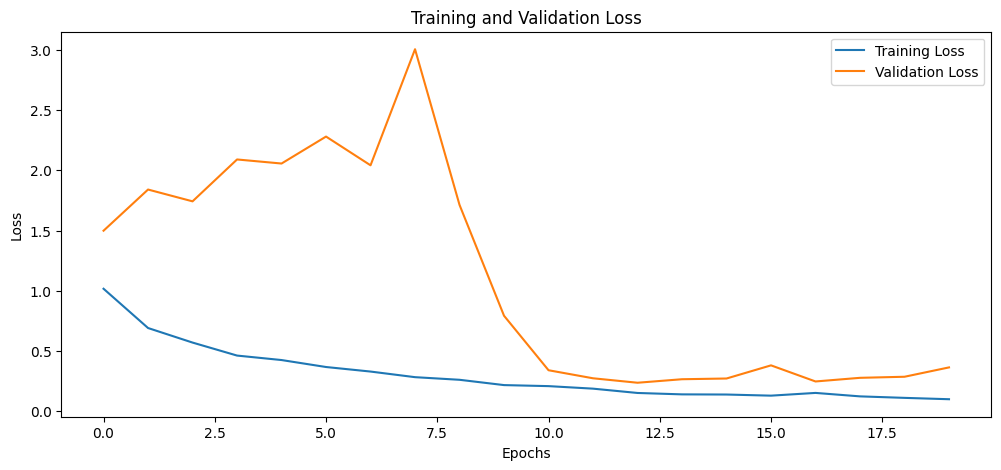

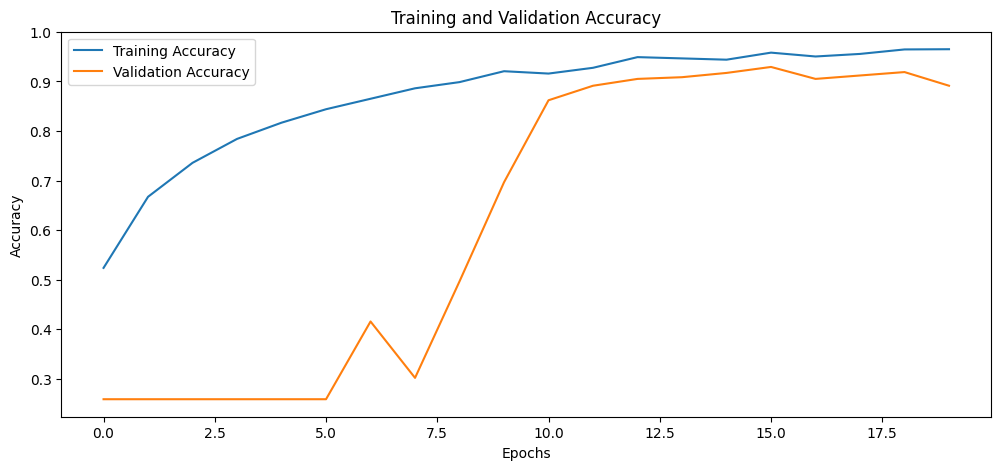

19/19 [==============================] - 2s 59ms/step


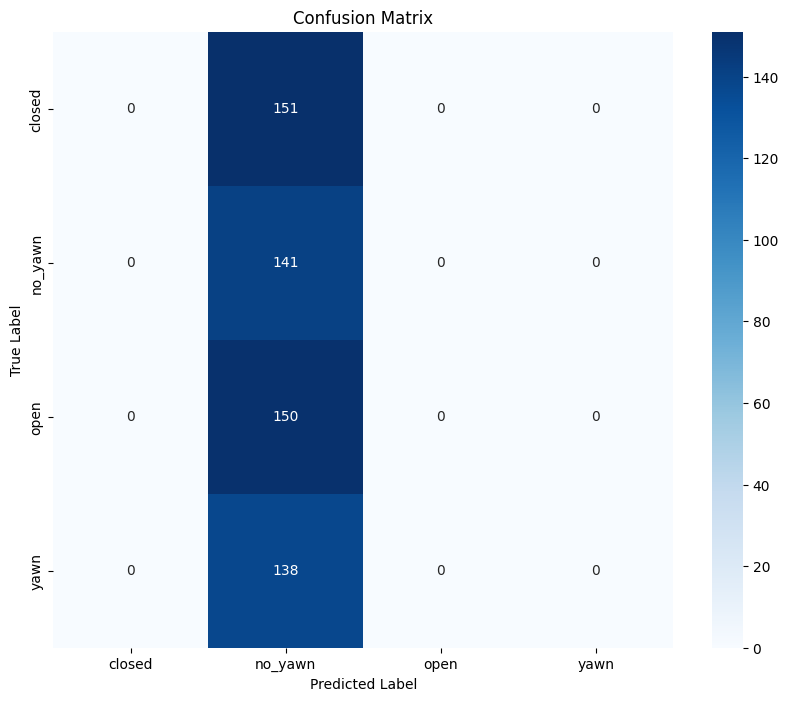

In [90]:
from sklearn.metrics import confusion_matrix, classification_report


# Plot the training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Predict the class labels for the test set
y_pred = model.predict(X_test_3channel)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Performance Metrics

In [91]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted')

# Create a dataframe to display the evaluation metrics
metrics_6 = pd.DataFrame({
    'Metric': ['Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F1 Score'],
    'Value': [accuracy, precision, recall, f1_score]
})

metrics_6

C:\Program Files\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metric     Value
0            Accuracy  0.243103
1  Weighted Precision  0.059099
2     Weighted Recall  0.243103
3   Weighted F1 Score  0.095083

# Resizing and re-experimenting the Hypermodel with Autoencoded images

In [46]:
# Function to resize images
def resize_images(images, new_size=(128, 128)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, new_size)
        resized_images.append(resized_img)
    return np.array(resized_images)

# Create a custom hypermodel that includes EfficientNet variants
class MyHyperModel(HyperModel):

    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        efficientnet_variant = hp.Choice('efficientnet_variant', values=['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6'])#, 'B7'])

        if efficientnet_variant == 'B0':
            base_model = EfficientNetB0(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B1':
            base_model = EfficientNetB1(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B2':
            base_model = EfficientNetB2(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B3':
            base_model = EfficientNetB3(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B4':
            base_model = EfficientNetB4(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B5':
            base_model = EfficientNetB5(include_top=False, input_shape=self.input_shape, weights='imagenet')
#         elif efficientnet_variant == 'B6':
#             base_model = EfficientNetB6(include_top=False, input_shape=self.input_shape, weights='imagenet')
        else:
            base_model = EfficientNetB6(include_top=False, input_shape=self.input_shape, weights='imagenet')

        model = tf.keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return model

input_shape = (128, 128, 1)  # Adjust input shape accordingly
num_classes = len(classes)   # Replace `classes` with the list of your target classes

# Convert single-channel input data to 3-channel format
X_train_3channel = np.repeat(decoded_imgs_train, 3, axis=-1)
X_test_3channel = np.repeat(decoded_imgs, 3, axis=-1)

# Resize the images to the new size
new_size = (128, 128)
X_train_resized = resize_images(X_train_3channel, new_size)
X_test_resized = resize_images(X_test_3channel, new_size)


hypermodel = MyHyperModel(input_shape=(128, 128, 3), num_classes=num_classes)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,  # Adjust the number of trials based on available resources
    executions_per_trial=1,
    directory='my_dir',
    project_name='efficientnet_hyperparameter_tuning_2'
)

tuner.search(X_train_resized, y_train, epochs=10, validation_split=0.2)  # Adjust the number of epochs based on available resources

# Get the optimal hyperparameters
best_hps_3 = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best EfficientNet variant
best_efficientnet_variant = best_hps_3.get('efficientnet_variant')
print(f"Best EfficientNet variant: {best_efficientnet_variant}")

# Build the model with the optimal hyperparameters and train it
model = hypermodel.build(best_hps_3)
model.fit(X_train_resized, y_train, epochs=10, validation_split=0.2, batch_size = 8)  # Adjust the number of epochs based on available resources

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_resized, y_test)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

Trial 10 Complete [00h 01m 01s]
val_accuracy: 0.2715517282485962

Best val_accuracy So Far: 0.7866379022598267
Total elapsed time: 00h 10m 38s
INFO:tensorflow:Oracle triggered exit
Best EfficientNet variant: B1
Epoch 1/10
232/232 [==============================] - 19s 60ms/step - loss: 0.7104 - accuracy: 0.7010 - val_loss: 1.8182 - val_accuracy: 0.2263
Epoch 2/10
232/232 [==============================] - 13s 56ms/step - loss: 0.3714 - accuracy: 0.8335 - val_loss: 1.2448 - val_accuracy: 0.3858
Epoch 3/10
232/232 [==============================] - 13s 56ms/step - loss: 0.2605 - accuracy: 0.8976 - val_loss: 1.3138 - val_accuracy: 0.4138
Epoch 4/10
232/232 [==============================] - 13s 56ms/step - loss: 0.2031 - accuracy: 0.9262 - val_loss: 1.7793 - val_accuracy: 0.3642
Epoch 5/10
232/232 [==============================] - 13s 56ms/step - loss: 0.1473 - accuracy: 0.9520 - val_loss: 1.6161 - val_accuracy: 0.2543
Epoch 6/10
232/232 [==============================] - 13s 56ms/step -

## Get the best trial and highest validation accuracy


In [47]:
# Get the best trial and highest validation accuracy
best_trial_2 = tuner.oracle.get_best_trials(num_trials=1)[0]
best_val_accuracy_2 = best_trial_2.metrics.get_best_value('val_accuracy')

# Print the best validation accuracy and test accuracy
print(f"Best validation accuracy: {best_val_accuracy_2:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")


Best validation accuracy: 0.7866
Test accuracy: 0.8845


## Plot the training and validation loss/accuracy and Confusion Matrix


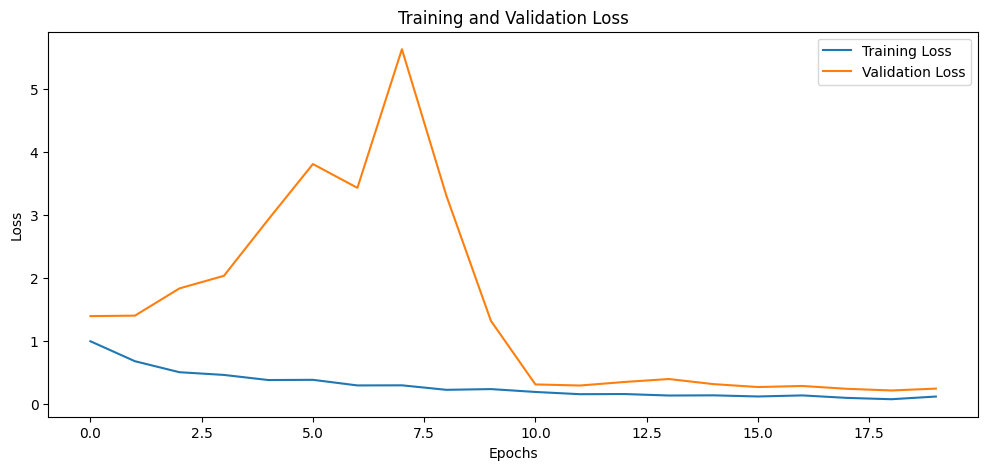

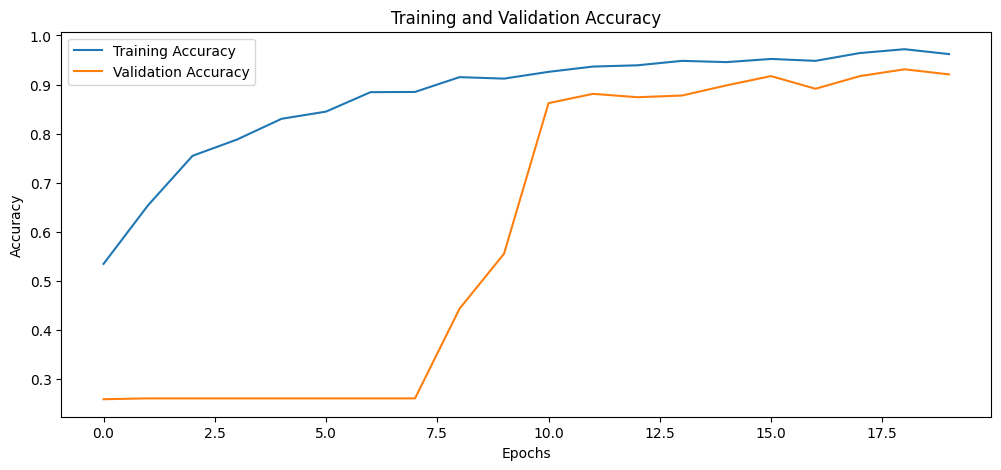

19/19 [==============================] - 1s 17ms/step


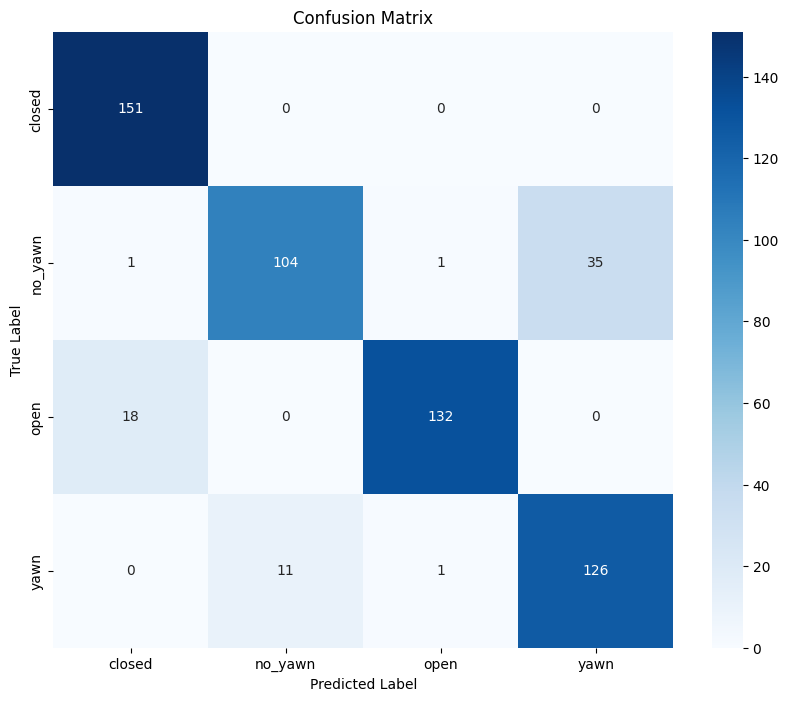

In [48]:
from sklearn.metrics import confusion_matrix, classification_report


# Plot the training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Predict the class labels for the test set
y_pred = model.predict(X_test_resized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Performance Evaluation

In [49]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted')

# Create a dataframe to display the evaluation metrics
metrics_2 = pd.DataFrame({
    'Metric': ['Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F1 Score'],
    'Value': [accuracy, precision, recall, f1_score]
})

metrics_2

Metric     Value
0            Accuracy  0.884483
1  Weighted Precision  0.892065
2     Weighted Recall  0.884483
3   Weighted F1 Score  0.883395

# Base model training autoencoded images against original test data

C:\Program Files\Python310\lib\site-packages\keras\applications\efficientnet.py:292: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 64 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Epoch 1/20
73/73 [==============================] - 8s 55ms/step - loss: 1.0177 - accuracy: 0.5237 - val_loss: 1.4994 - val_accuracy: 0.2586
Epoch 2/20
73/73 [==============================] - 3s 44ms/step - loss: 0.6918 - accuracy: 0.6672 - val_loss: 1.8410 - val_accuracy: 0.2586
Epoch 3/20
73/73 [==============================] - 3s 44ms/step - loss: 0.5710 - accuracy: 0.7358 - val_loss: 1.7430 - val_accuracy: 0.2586
Epoch 4/20
73/73 [==============================] - 3s 45ms/step - loss: 0.4632 - accuracy: 0.7841 - val_loss: 2.0905 - val_accuracy: 0.2586
Epoch 5/20
73/73 [==============================] - 3s 45ms/step - loss: 0.4260 - accuracy: 0.8168 - val_loss: 2.0568 - val_accuracy: 0.2586
Epoch 6/20
73/73 [==============================] - 3s 45ms/step - loss: 0.3682 - accuracy: 0.8440 - val_loss: 2.2805 - val_accuracy: 0.2586
Epoch 7/20
73/73 [==============================] - 3s 44ms/step - loss: 0.3305 - accuracy: 0.8651 - val_loss: 2.0420 - val_accuracy: 0.4155
Epoch 8/20
73

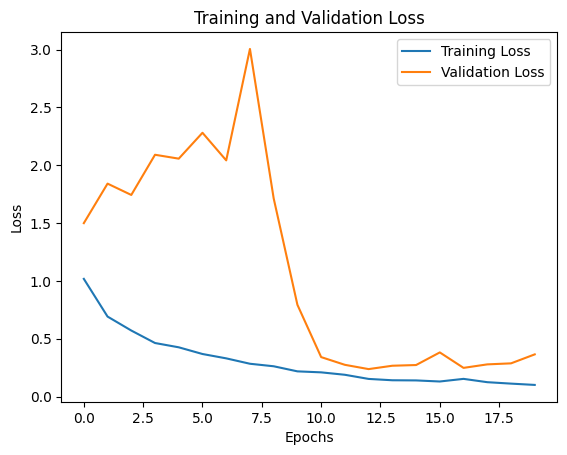

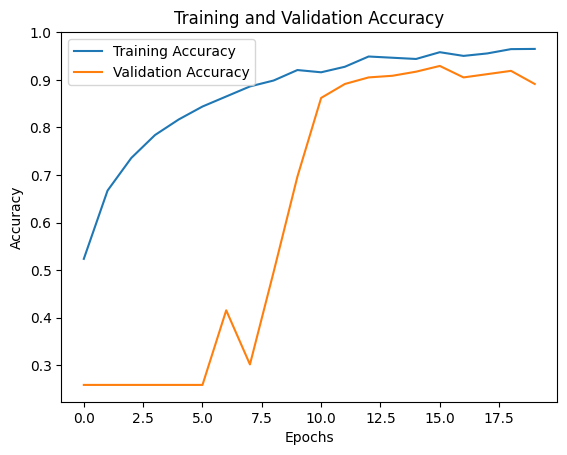

In [50]:
num_classes = len(classes)

class Hybrid(Model):
    def __init__(self):
        super(Hybrid, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)),
          layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)]) # Update the output size to 32x32

        self.efficientnet = tf.keras.applications.EfficientNetB0(
            include_top=False, weights=None, input_shape=(32, 32, 64), pooling='avg'
        )

        self.classifier = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        efficientnet_out = self.efficientnet(encoded)
        classification = self.classifier(efficientnet_out)
        return classification

decoded_X_train = decoded_imgs_train.reshape(-1, 256, 256, 1)
decoded_X_test = decoded_imgs.reshape(-1, 256, 256, 1)

hybrid_model = Hybrid()
hybrid_model.compile(optimizer='adam', loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
history = hybrid_model.fit(decoded_X_train, y_train,
                epochs=20,
                shuffle=True,
                validation_data=(X_test, y_test))



#Plot the training and validation loss
plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#Plot the training and validation accuracy
plt.figure()
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


# Hypermodel of autoencoded images vs original test data
The resources of the computer was not enough to run it, hence commenting out majority of the EfficientNet model

In [92]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

tf.keras.mixed_precision.set_global_policy('float32')

class ConvertToFloat32(Layer):
    def __init__(self, **kwargs):
        super(ConvertToFloat32, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.cast(inputs, tf.float32)

global_policy = tf.keras.mixed_precision.global_policy()
target_dtype = global_policy.compute_dtype

class MyHyperModel(HyperModel):

    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        efficientnet_variant = hp.Choice('efficientnet_variant', values=['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6'])

        input_tensor = layers.Input(shape=self.input_shape, dtype=target_dtype)

        if efficientnet_variant == 'B0':
            base_model = EfficientNetB0(include_top=False, input_tensor=input_tensor, weights='imagenet')
#         elif efficientnet_variant == 'B1':
#             base_model = EfficientNetB1(include_top=False, input_tensor=input_tensor, weights='imagenet')
#         elif efficientnet_variant == 'B2':
#             base_model = EfficientNetB2(include_top=False, input_tensor=input_tensor, weights='imagenet')
#         elif efficientnet_variant == 'B3':
#             base_model = EfficientNetB3(include_top=False, input_tensor=input_tensor, weights='imagenet')
#         elif efficientnet_variant == 'B4':
#             base_model = EfficientNetB4(include_top=False, input_tensor=input_tensor, weights='imagenet')
#         elif efficientnet_variant == 'B5':
#             base_model = EfficientNetB5(include_top=False, input_tensor=input_tensor, weights='imagenet')
        else:
            base_model = EfficientNetB1(include_top=False, input_tensor=input_tensor, weights='imagenet')

        model = tf.keras.Sequential([
            ConvertToFloat32(input_shape=self.input_shape),
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return model

input_shape = (256, 256, 1)
num_classes = len(classes)

X_train_3channel = np.repeat(decoded_imgs_train, 3, axis=-1).astype(np.float32)
X_test_3channel = np.repeat(X_test, 3, axis=-1).astype(np.float32)

hypermodel = MyHyperModel(input_shape=(256, 256, 3), num_classes=num_classes)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='efficientnet_hyperparameter_tuning_4'
)

tuner.search(X_train_3channel, y_train, epochs=10, validation_split=0.2)

best_hps_4 = tuner.get_best_hyperparameters(num_trials=1)[0]

model = hypermodel.build(best_hps_4)
model.fit(X_train_3channel, y_train, epochs=10, validation_split=0.2, batch_size = 1)

test_loss, test_accuracy = model.evaluate(X_test_3channel, y_test)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

Trial 5 Complete [00h 02m 44s]
val_accuracy: 0.29525861144065857

Best val_accuracy So Far: 0.4590517282485962
Total elapsed time: 00h 13m 40s
INFO:tensorflow:Oracle triggered exit


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

## Get the best trial and highest validation accuracy


In [93]:
# Get the best trial and highest validation accuracy
best_trial_4 = tuner.oracle.get_best_trials(num_trials=1)[0]
best_val_accuracy_4 = best_trial_4.metrics.get_best_value('val_accuracy')

# Print the best validation accuracy and test accuracy
print(f"Best validation accuracy: {best_val_accuracy_4:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Best validation accuracy: 0.4591
Test accuracy: 0.4931


## Plot the training and validation loss/accuracy and Confusion Matrix

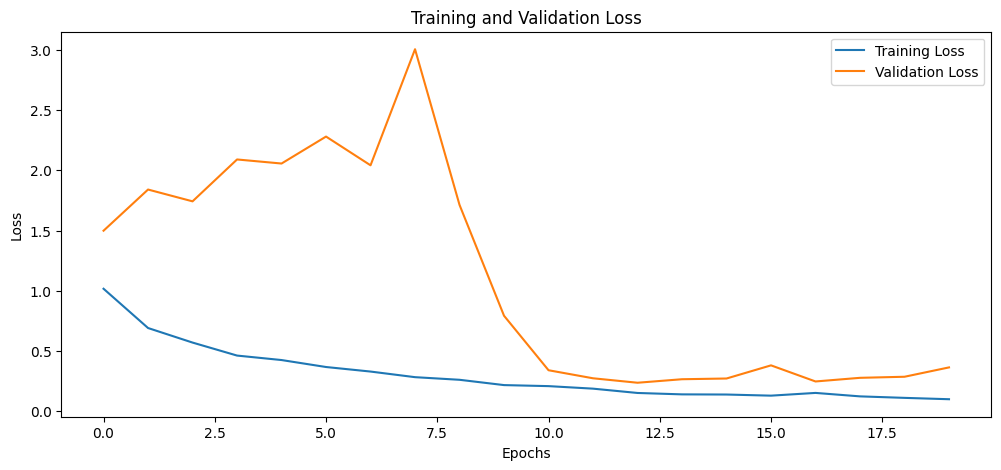

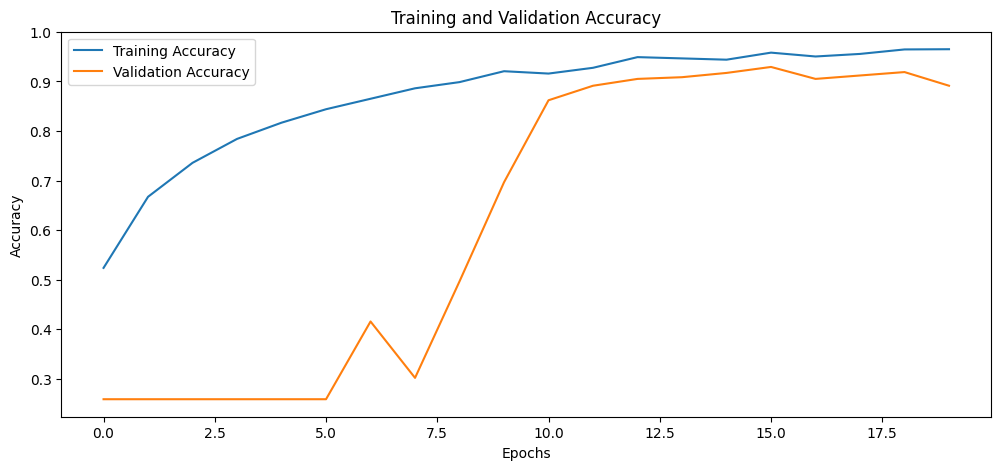

19/19 [==============================] - 2s 49ms/step


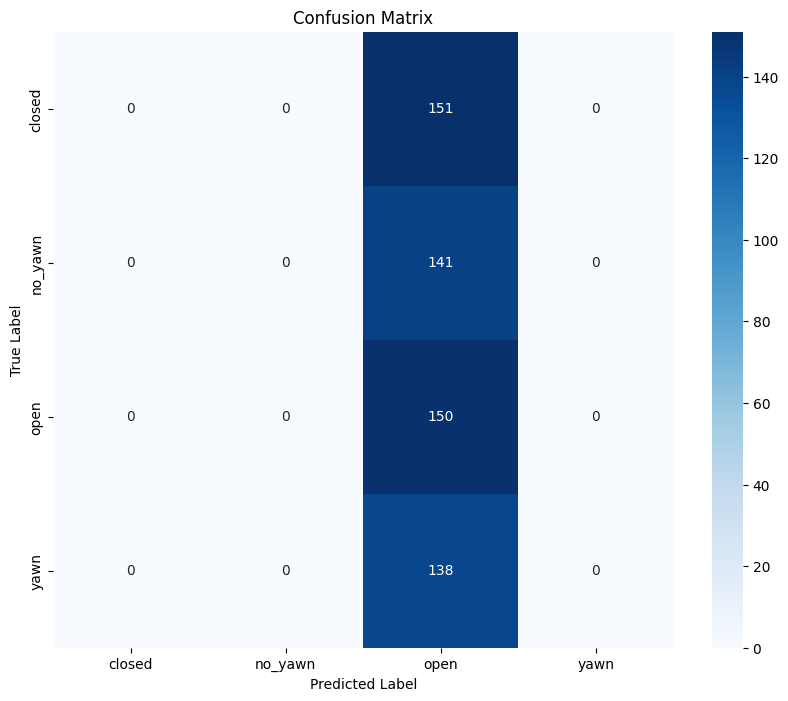

In [95]:
from sklearn.metrics import confusion_matrix, classification_report


# Plot the training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Predict the class labels for the test set
y_pred = model.predict(X_test_3channel)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Performance Metrics

In [96]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted')

# Create a dataframe to display the evaluation metrics
metrics_4 = pd.DataFrame({
    'Metric': ['Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F1 Score'],
    'Value': [accuracy, precision, recall, f1_score]
})

metrics_4

C:\Program Files\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metric     Value
0            Accuracy  0.258621
1  Weighted Precision  0.066885
2     Weighted Recall  0.258621
3   Weighted F1 Score  0.106282

# Hyperparameter Tuning for autoencoded images vs original data after resizing

In [55]:
# Function to resize images
def resize_images(images, new_size=(128, 128)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, new_size)
        resized_images.append(resized_img)
    return np.array(resized_images)

# Create a custom hypermodel that includes EfficientNet variants
class MyHyperModel(HyperModel):

    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        efficientnet_variant = hp.Choice('efficientnet_variant', values=['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6'])#, 'B7'])

        if efficientnet_variant == 'B0':
            base_model = EfficientNetB0(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B1':
            base_model = EfficientNetB1(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B2':
            base_model = EfficientNetB2(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B3':
            base_model = EfficientNetB3(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B4':
            base_model = EfficientNetB4(include_top=False, input_shape=self.input_shape, weights='imagenet')
        elif efficientnet_variant == 'B5':
            base_model = EfficientNetB5(include_top=False, input_shape=self.input_shape, weights='imagenet')
#         elif efficientnet_variant == 'B6':
#             base_model = EfficientNetB6(include_top=False, input_shape=self.input_shape, weights='imagenet')
        else:
            base_model = EfficientNetB6(include_top=False, input_shape=self.input_shape, weights='imagenet')

        model = tf.keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return model

input_shape = (128, 128, 1)  # Adjust input shape accordingly
num_classes = len(classes)   # Replace `classes` with the list of your target classes

# Convert single-channel input data to 3-channel format
X_train_3channel = np.repeat(decoded_imgs_train, 3, axis=-1)
X_test_3channel = np.repeat(X_test, 3, axis=-1)

# Resize the images to the new size
new_size = (128, 128)
X_train_resized = resize_images(X_train_3channel, new_size)
X_test_resized = resize_images(X_test_3channel, new_size)


hypermodel = MyHyperModel(input_shape=(128, 128, 3), num_classes=num_classes)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,  # Adjust the number of trials based on available resources
    executions_per_trial=1,
    directory='my_dir',
    project_name='efficientnet_hyperparameter_tuning_5'
)

tuner.search(X_train_resized, y_train, epochs=10, validation_split=0.2)  # Adjust the number of epochs based on available resources

# Get the optimal hyperparameters
best_hps_5 = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best EfficientNet variant
best_efficientnet_variant = best_hps_5.get('efficientnet_variant')
print(f"Best EfficientNet variant: {best_efficientnet_variant}")

# Build the model with the optimal hyperparameters and train it
model = hypermodel.build(best_hps_5)
model.fit(X_train_resized, y_train, epochs=10, validation_split=0.2, batch_size = 8)  # Adjust the number of epochs based on available resources

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_resized, y_test)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

Trial 10 Complete [00h 02m 47s]
val_accuracy: 0.8017241358757019

Best val_accuracy So Far: 0.857758641242981
Total elapsed time: 00h 15m 20s
INFO:tensorflow:Oracle triggered exit
Best EfficientNet variant: B4
Epoch 1/10
232/232 [==============================] - 26s 84ms/step - loss: 0.4579 - accuracy: 0.7893 - val_loss: 1.7547 - val_accuracy: 0.2284
Epoch 2/10
232/232 [==============================] - 19s 81ms/step - loss: 0.1861 - accuracy: 0.9375 - val_loss: 3.0005 - val_accuracy: 0.3750
Epoch 3/10
232/232 [==============================] - 19s 81ms/step - loss: 0.1283 - accuracy: 0.9607 - val_loss: 0.3040 - val_accuracy: 0.8750
Epoch 4/10
232/232 [==============================] - 19s 81ms/step - loss: 0.0702 - accuracy: 0.9811 - val_loss: 0.3819 - val_accuracy: 0.8491
Epoch 5/10
232/232 [==============================] - 19s 81ms/step - loss: 0.0500 - accuracy: 0.9849 - val_loss: 2.1604 - val_accuracy: 0.2823
Epoch 6/10
232/232 [==============================] - 19s 82ms/step - 

## Get the best trial and highest validation accuracy


In [56]:
# Get the best trial and highest validation accuracy
best_trial_5 = tuner.oracle.get_best_trials(num_trials=1)[0]
best_val_accuracy_5 = best_trial_5.metrics.get_best_value('val_accuracy')

# Print the best validation accuracy and test accuracy
print(f"Best validation accuracy: {best_val_accuracy_5:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Best validation accuracy: 0.8578
Test accuracy: 0.4931


## Plot the training and validation loss/accuracy and Confusion Matrix

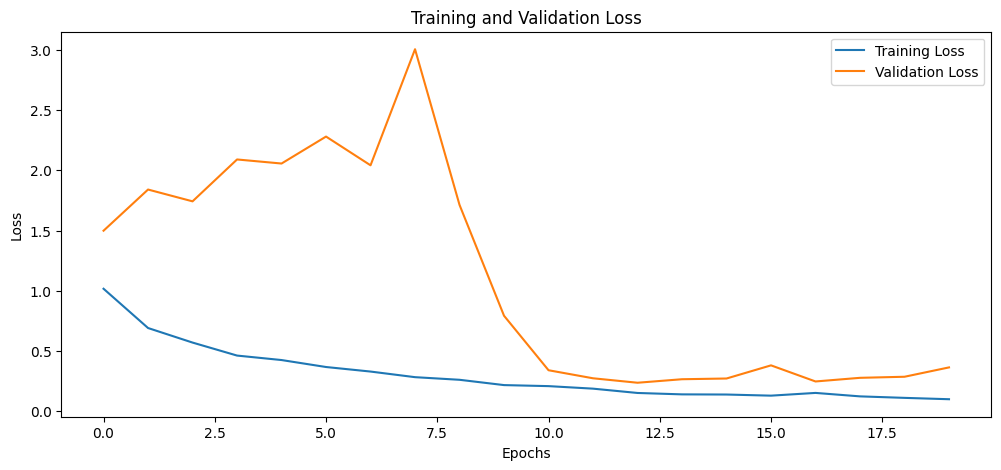

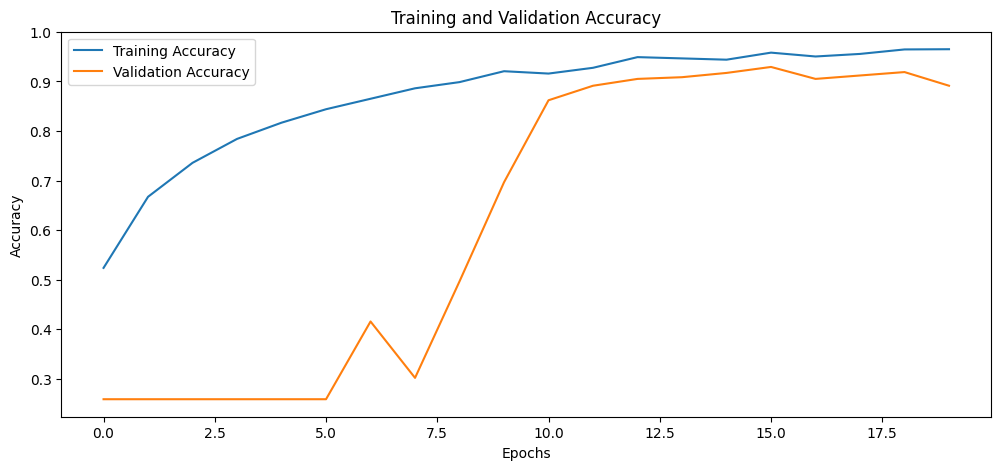

19/19 [==============================] - 2s 29ms/step


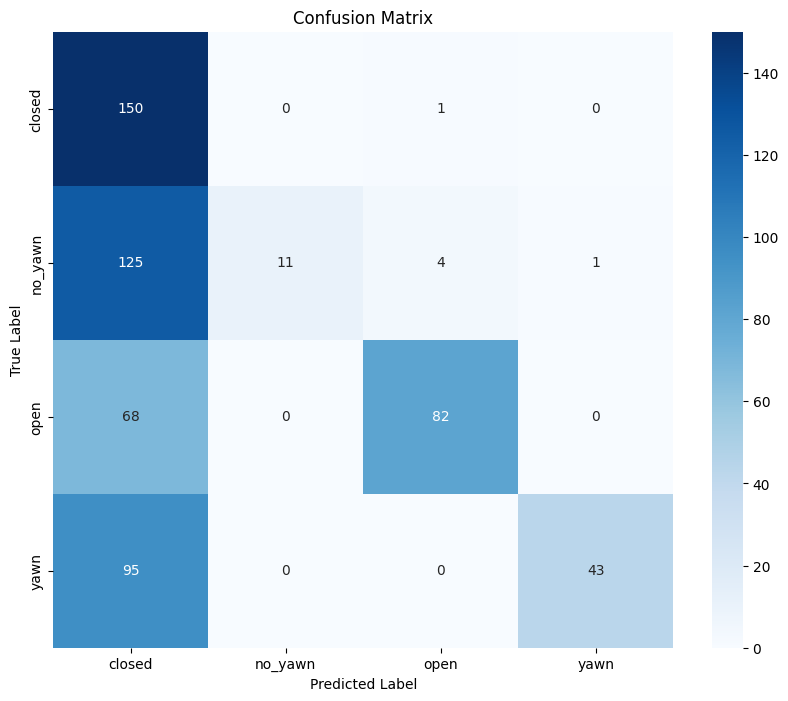

In [57]:
from sklearn.metrics import confusion_matrix, classification_report


# Plot the training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Predict the class labels for the test set
y_pred = model.predict(X_test_resized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Performance Metrics

In [58]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted')

# Create a dataframe to display the evaluation metrics
metrics_5 = pd.DataFrame({
    'Metric': ['Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F1 Score'],
    'Value': [accuracy, precision, recall, f1_score]
})

metrics_5

Metric     Value
0            Accuracy  0.493103
1  Weighted Precision  0.808544
2     Weighted Recall  0.493103
3   Weighted F1 Score  0.459180